In [1]:
try:
    import google.colab # type: ignore
    IN_COLAB = True
except:
    IN_COLAB = False

import os, sys
chapter = "chapter1_transformer_interp"
repo = "ARENA_3.0"

# Code to download the necessary files (e.g. solutions, test funcs)
os.chdir("/home/will/src/ai/arena/monthly/november")
if not os.path.exists(chapter):
    # !wget https://github.com/callummcdougall/ARENA_3.0/archive/refs/heads/main.zip
    print(os.getcwd())
    !unzip ./main.zip 'ARENA_3.0-main/chapter1_transformer_interp/exercises/*'
    sys.path.append(f"content/{repo}-main/{chapter}/exercises")
    # os.remove("main.zip")
    os.rename(f"{repo}-main/{chapter}", chapter)
    os.rmdir(f"{repo}-main")
    os.chdir(f"{chapter}/exercises")


In [2]:
import os
import sys
from pathlib import Path

import numpy as np
import torch as t
from eindex import eindex
from transformer_lens import utils

t.set_grad_enabled(False)

os.chdir("/home/will/src/ai/arena/monthly/november/" + chapter + "/exercises")

exercises_dir = Path.cwd()

section_dir = exercises_dir / "monthly_algorithmic_problems" / "november24_trigrams"
assert section_dir.name == "november24_trigrams", "Please navigate to the correct directory using os.chdir"

from monthly_algorithmic_problems.november24_trigrams.dataset import BigramDataset
from monthly_algorithmic_problems.november24_trigrams.model import create_model
from plotly_utils import imshow

device = t.device("cuda" if t.cuda.is_available() else "cpu")

In [3]:
import einops
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
from rich.table import Table

In [4]:
dataset = BigramDataset(size=10, d_vocab=10, seq_len=10, trigram_prob=0.1, device=device, seed=42)
print(dataset.trigrams)
print(dataset.toks)

Generating dataset: 100%|███████████████████████| 8/8 [00:00<00:00, 2179.99it/s]

{(2, 7, 6), (2, 5, 5), (3, 8, 4), (2, 0, 5), (0, 4, 0), (4, 6, 5), (9, 7, 9), (6, 3, 1), (9, 3, 1)}
tensor([[9, 3, 1, 9, 6, 2, 0, 5, 2, 7],
        [9, 7, 9, 3, 1, 3, 7, 0, 9, 0],
        [9, 6, 9, 5, 4, 8, 8, 6, 0, 0],
        [0, 0, 1, 3, 0, 1, 1, 7, 9, 4],
        [3, 8, 4, 3, 7, 8, 1, 4, 1, 6],
        [3, 2, 0, 5, 8, 5, 3, 7, 7, 5],
        [9, 1, 5, 1, 9, 1, 4, 0, 3, 7],
        [5, 7, 1, 5, 7, 5, 8, 5, 4, 1],
        [1, 0, 9, 0, 9, 1, 8, 9, 6, 7],
        [6, 0, 9, 5, 2, 9, 1, 7, 8, 6]])


In [5]:
def reload_model():
  model = create_model(
      d_vocab=75,
      seq_len=50,
      d_model=32,
      d_head=16,
      n_layers=1,
      n_heads=1,
      d_mlp=20,
      normalization_type=None,
      seed=40,
      device=device,
  )

  state_dict = t.load(section_dir / "trigram_model.pt", weights_only=True, map_location=t.device("cpu"))
  state_dict = model.fold_value_biases(state_dict)
  model.load_state_dict(state_dict, strict=False)
  return model

model = reload_model()

In [6]:
BIGRAM_PROB = 0.05
BATCH_SIZE = 2500

dataset = BigramDataset(
    size=BATCH_SIZE,
    d_vocab=model.cfg.d_vocab,
    seq_len=model.cfg.n_ctx,
    trigram_prob=BIGRAM_PROB,
    device=device,
    seed=40,
)

logits, cache = model.run_with_cache(dataset.toks)
logprobs = logits[:, :-1].log_softmax(-1)
probs = logprobs.softmax(-1)

targets = dataset.toks[:, 1:]
logprobs_correct = eindex(logprobs, targets, "batch seq [batch seq]")
probs_correct = eindex(probs, targets, "batch seq [batch seq]")

print(f"Average cross entropy loss: {-logprobs_correct.mean().item():.3f}")
print(f"Mean probability on correct label: {probs_correct.mean():.3f}")
print(f"Median probability on correct label: {probs_correct.median():.3f}")
print(f"Min probability on correct label: {probs_correct.min():.3f}")

imshow(
    probs_correct[:50],
    width=600,
    height=600,
    title="Sample model probabilities",
    labels={"x": "Seq posn", "y": "Batch idx"},
)

Generating dataset: 100%|███████████████████████| 48/48 [00:00<00:00, 91.19it/s]


Average cross entropy loss: 4.157
Mean probability on correct label: 0.050
Median probability on correct label: 0.013
Min probability on correct label: 0.008


In [7]:
def get_trigram_seq(dataset, batch_pos):
    # There must be a faster way than this!
    trigram_pairs = {(trigram[0], trigram[1]): trigram[2] for trigram in dataset.trigrams}

    trigram_seq_positions = []
    trigram_completions = []

    # We ignore the last sequence position (for now) since its prediction is always
    # trimmed off in training.

    for i, tok in enumerate(dataset.toks[batch_pos, 1:-1]):
        if (completion := trigram_pairs.get(
            (dataset.toks[batch_pos, i].item(), tok.item()))) is not None:
            trigram_seq_positions += [i + 1]
            trigram_completions += [completion]


    return trigram_seq_positions, trigram_completions

def print_all_trigrams():
    [print(val) for val in sorted(dataset.trigrams, key=lambda x: x[0] + x[1] / 10**2 + x[2] / 10**4)]

print_all_trigrams()

(0, 17, 26)
(0, 42, 36)
(0, 44, 53)
(1, 40, 72)
(1, 68, 72)
(1, 71, 26)
(2, 5, 17)
(2, 9, 59)
(2, 20, 57)
(2, 23, 55)
(2, 30, 55)
(2, 35, 62)
(2, 46, 35)
(2, 47, 28)
(3, 2, 62)
(3, 16, 71)
(3, 58, 32)
(3, 74, 28)
(4, 10, 3)
(4, 27, 14)
(4, 47, 23)
(4, 54, 12)
(4, 55, 72)
(4, 64, 20)
(5, 8, 0)
(5, 25, 55)
(5, 67, 59)
(5, 73, 25)
(6, 1, 54)
(6, 13, 39)
(6, 15, 47)
(6, 17, 40)
(6, 53, 52)
(7, 26, 60)
(7, 42, 17)
(7, 62, 73)
(8, 49, 40)
(9, 0, 37)
(9, 14, 65)
(9, 20, 2)
(9, 22, 2)
(9, 50, 74)
(9, 71, 20)
(10, 2, 67)
(10, 7, 56)
(10, 24, 42)
(10, 29, 34)
(10, 43, 36)
(11, 5, 53)
(11, 9, 30)
(11, 23, 37)
(11, 51, 66)
(11, 63, 36)
(12, 0, 20)
(12, 9, 26)
(12, 12, 4)
(12, 15, 54)
(12, 45, 61)
(12, 60, 48)
(13, 1, 22)
(13, 4, 8)
(13, 17, 16)
(13, 21, 46)
(13, 35, 72)
(13, 36, 50)
(13, 44, 13)
(13, 53, 35)
(14, 13, 9)
(14, 20, 1)
(14, 38, 30)
(14, 56, 69)
(15, 4, 50)
(15, 28, 40)
(15, 41, 52)
(15, 43, 37)
(16, 5, 60)
(16, 14, 5)
(16, 23, 9)
(16, 25, 61)
(16, 28, 16)
(16, 43, 68)
(16, 50, 72)
(16

In [8]:
get_trigram_seq(dataset, 0)

([6, 43], [0, 36])

### Compute trigram positions without explicit for loops

In [9]:
pairs = dataset.toks.unfold(dimension=1, size=2, step=1)
patterns = t.tensor([[trigram[0], trigram[1]] for trigram in dataset.trigrams])

# Match all pairs against all patterns.
# matches gives the position where a particular trigram matches.
matches = (pairs.unsqueeze(2) == patterns.reshape(1, 1, len(patterns), 2)).all(dim=-1) # [batch, seq - 1, num_patterns]

# trigram_pos gives the starting position of *any* valid trigram.
batch_idx, seq_idx = t.where(matches.any(dim=-1))

# print a random trigram
print(dataset.toks[batch_idx[0], seq_idx[0]: seq_idx[0] + 3])

tensor([56, 49,  0])


# QK Circuits

In [10]:
def visualize_attn(batch=0):
    trigrams = seq_idx[batch_idx == batch]
    attn = cache['blocks.0.attn.hook_pattern'][batch, 0] # select batch, head = 0 -> [q_seq, k_seq]
    
    bound = max(attn.min().abs(), attn.max().abs())
    plt.imshow(attn, vmin=0, vmax=bound, cmap='Blues')
    plt.xlabel("Key")
    plt.ylabel("Query")

    correct_predictions = t.where(logits[batch, :-1].argmax(dim=1) == dataset.toks[batch, 1:])
    plt.plot([0.5] * len(correct_predictions), correct_predictions, "g", marker="$✓$")
    
    mask = t.zeros_like(attn)
    mask[trigrams] = 1
    mask[trigrams + 1] = 1
    plt.imshow(mask, alpha=0.05, cmap='gray')

# Also visualize if the model makes a correct prediction

interact(visualize_attn, batch=(0, logits.shape[0] - 1, 1))

interactive(children=(IntSlider(value=0, description='batch', max=2499), Output()), _dom_classes=('widget-inte…

<function __main__.visualize_attn(batch=0)>

In the plot above, the horizontal bars encompass the first two characters of a trigram.
The green tick is where the model correctly predicts the next token.
> Note, sometimes the model will predict a correct token randomly (i.e. a green tick with no
> horizontal bar.)
>
> Also, sometimes the model will fail to fire on a trigram (i.e. a
> horizontal bar with no change in attention pattern.)

From the attention pattern, we can get an inkling of what's going on:

1. By default, each token attends to itself.
2. If the start of a trigram is present in the previous token, *and* the current token contains the continuation,
the head attends (mostly) to the previous token.

# TODO:
- compile some stats on model accuracy with/without trigrams present, including
verifying that when the attention pattern "misfires" and a trigram is present,
the prediction rate of the continuation should be 1/d_vocab

Are positional embeddings important?

Compute attention patterns after swapping positional embeddings for neighboring tokens

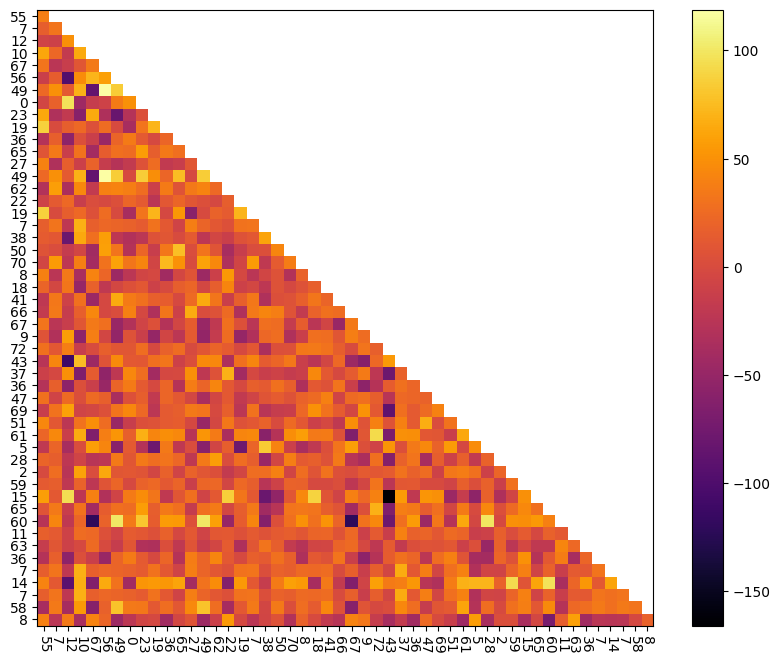

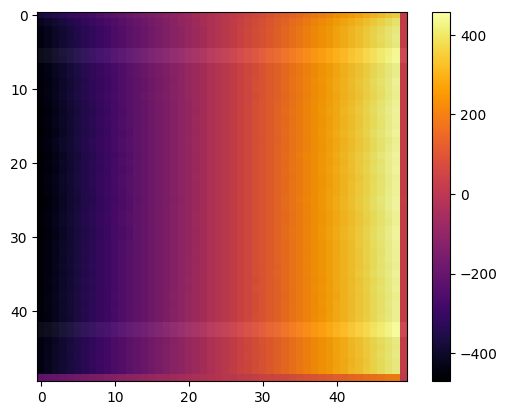

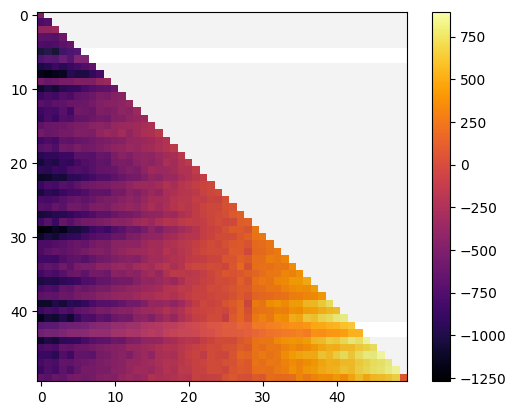

In [11]:
def mask_trigrams(attn, batch=0):
    trigrams = seq_idx[batch_idx == batch]
    mask = t.zeros_like(attn[batch])
    mask[trigrams] = 1
    mask[trigrams + 1] = 1
    plt.imshow(mask, alpha=0.05, cmap='gray')

batch = 0

# Token only, no positional embeddings
q_tok = (cache['hook_embed']) @ model.W_Q[0, 0] + model.b_Q[0, 0]
k_tok = (cache['hook_embed']) @ model.W_K[0, 0] + model.b_K[0, 0]
attn_tok = einops.einsum(q_tok, k_tok, "... qseq dhead, ... kseq dhead -> ... qseq kseq").masked_fill_(t.triu(t.ones(q_tok.shape[-2], q_tok.shape[-2]).bool(), diagonal=1), -t.inf)

# Positional embedding only
q_pos = (cache['pos_embed']) @ model.W_Q[0, 0] + model.b_Q[0, 0]
k_pos = (cache['pos_embed']) @ model.W_K[0, 0] + model.b_K[0, 0]
attn_pos = einops.einsum(q_pos, k_pos, "... qseq dhead, ... kseq dhead -> ... qseq kseq")#.masked_fill_(t.triu(t.ones(q_pos.shape[-2], q_pos.shape[-2]).bool(), diagonal=1), -t.inf)

# Both embeddings, pre-softmax
q = q_tok + q_pos
k = k_tok + k_pos
attn = einops.einsum(q, k, "... qseq dhead, ... kseq dhead -> ... qseq kseq").masked_fill_(t.triu(t.ones(q.shape[-2], q.shape[-2]).bool(), diagonal=1), -t.inf)

vmin = min(t.tril(attn_tok[batch], diagonal=-1).min(), t.tril(attn_pos[batch], diagonal=-1).min(), t.tril(attn[batch], diagonal=-1).min())
vmax = max(t.tril(attn_tok[batch], diagonal=-1).max(), t.tril(attn_pos[batch], diagonal=-1).max(), t.tril(attn[batch], diagonal=-1).max())

fig, ax = plt.subplots(figsize=(10, 8))
# f = plt.imshow(attn_tok[batch], vmin=vmin, vmax=vmax)
f = ax.imshow(attn_tok[batch], cmap="inferno")
plt.colorbar(f)
ax.set_xticks(np.arange(dataset.toks.shape[1]), dataset.toks[batch].numpy(), rotation=-90)
ax.set_yticks(np.arange(dataset.toks.shape[1]), dataset.toks[batch].numpy())
# mask_trigrams(attn_tok, batch)
plt.show()


# f = plt.imshow(attn_pos[0], vmin=vmin, vmax=vmax)
f = plt.imshow(attn_pos[0], cmap="inferno")
plt.colorbar(f)
mask_trigrams(attn_pos, batch)
plt.show()


f = plt.imshow(attn[0], cmap="inferno")
plt.colorbar(f)

mask_trigrams(attn, batch)
plt.show()


Check I've properly reconstructed the key transformation:

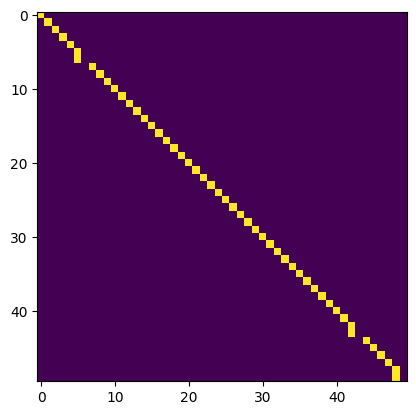

In [12]:
q_tok_only = (cache['hook_embed'] + cache['pos_embed']) @ model.W_Q[0, 0] + model.b_Q[0, 0]
k_tok_only = (cache['hook_embed'] + cache['pos_embed']) @ model.W_K[0, 0] + model.b_K[0, 0]

assert t.allclose(q_tok_only, cache['blocks.0.attn.hook_q'].squeeze(2))
assert t.allclose(k_tok_only, cache['blocks.0.attn.hook_k'].squeeze(2))

q = (cache['hook_embed'] + cache['pos_embed']) @ model.W_Q[0, 0] + model.b_Q[0, 0]
k = (cache['hook_embed'] + cache['pos_embed']) @ model.W_K[0, 0] + model.b_K[0, 0]
attn = einops.einsum(q, k, "... qseq dhead, ... kseq dhead -> ... qseq kseq").masked_fill_(t.triu(t.ones(q.shape[-2], q.shape[-2]).bool(), diagonal=1), -t.inf).softmax(dim=-1)
plt.imshow(attn[0])
plt.show()


# How does the attention head calculate this pattern?

*Hypothesis:*
The query vector for each token is looking for a key vector emitted by 
a valid preceding element in the trigram.

E.g. the query vector for the token "21" might look for keys emitted by
the tokens "13" and "67".

There are also some cases where a trigram uses repeated elements, e.g.
    
    (72, 72, 48)
    (54, 54, 67)

In [13]:
from rich.console import Console

table = Table("Trigram")
table.add_column("Prediction")
table.add_column("Correct?")
table.add_column("Prediction in sequence")
table.add_column("Correct?")

random_dist = t.distributions.categorical.Categorical(t.ones(model.cfg.d_vocab))


for trigram in dataset.trigrams:
    prediction = model(t.tensor([[trigram[0], trigram[1]]]))[0, -1]
    correct = prediction.argmax() == trigram[2]
    
    prediction_in_sequence = model(t.tensor([[random_dist.sample() for _ in range(45)] + [trigram[0], trigram[1]]]))[0, -1]
    correct_in_sequence = prediction_in_sequence.argmax() == trigram[2]
    
    table.add_row(f"{trigram[0]}, {trigram[1]}, {trigram[2]}", 
                  f"{prediction.argmax().item()}" if correct.item() else f"[red bold]{prediction.argmax().item()}[/red bold]", 
                  f"{correct.item()}" if correct.item() else f"[red bold]{correct.item()}", 
                  str(prediction_in_sequence.argmax().item()), 
                  str(correct_in_sequence.item()))


console = Console()
console.print(table)

┏━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Trigram    ┃ Prediction ┃ Correct? ┃ Prediction in sequence ┃ Correct? ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ 17, 0, 43  │ 43         │ True     │ 43                     │ True     │
│ 45, 10, 47 │ 47         │ True     │ 47                     │ True     │
│ 2, 47, 28  │ 28         │ True     │ 28                     │ True     │
│ 34, 53, 47 │ 47         │ True     │ 47                     │ True     │
│ 10, 2, 67  │ 67         │ True     │ 67                     │ True     │
│ 17, 44, 15 │ 15         │ True     │ 15                     │ True     │
│ 22, 37, 37 │ 37         │ True     │ 37                     │ True     │
│ 49, 58, 28 │ 28         │ True     │ 28                     │ True     │
│ 46, 26, 42 │ 42         │ True     │ 42                     │ True     │
│ 59, 14, 68 │ 68         │ True     │ 68                     │ True     │
│ 58, 50, 45 │ 45         │ True     │ 45                     │ True     │
│ 56, 49, 0  │ 0          │ True     │ 0                      │ True     │
│ 61, 58, 56 │ 56         │ True     │ 56                     │ True     │
│ 1, 68, 72  │ 72         │ True     │ 72                     │ True     │
│ 9, 14, 65  │ 65         │ True     │ 65                     │ True     │
│ 2, 23, 55  │ 55         │ True     │ 55                     │ True     │
│ 12, 45, 61 │ 61         │ True     │ 61                     │ True     │
│ 32, 72, 3  │ 3          │ True     │ 3                      │ True     │
│ 56, 73, 3  │ 3          │ True     │ 3                      │ True     │
│ 69, 37, 61 │ 61         │ True     │ 61                     │ True     │
│ 15, 4, 50  │ 50         │ True     │ 50                     │ True     │
│ 40, 37, 47 │ 47         │ True     │ 47                     │ True     │
│ 72, 19, 18 │ 18         │ True     │ 18                     │ True     │
│ 57, 4, 73  │ 73         │ True     │ 73                     │ True     │
│ 32, 28, 18 │ 18         │ True     │ 18                     │ True     │
│ 11, 63, 36 │ 36         │ True     │ 36                     │ True     │
│ 13, 1, 22  │ 22         │ True     │ 22                     │ True     │
│ 16, 14, 5  │ 5          │ True     │ 5                      │ True     │
│ 41, 29, 41 │ 41         │ True     │ 41                     │ True     │
│ 6, 13, 39  │ 39         │ True     │ 39                     │ True     │
│ 55, 27, 72 │ 72         │ True     │ 72                     │ True     │
│ 65, 50, 67 │ 67         │ True     │ 67                     │ True     │
│ 7, 42, 17  │ 17         │ True     │ 17                     │ True     │
│ 10, 29, 34 │ 34         │ True     │ 34                     │ True     │
│ 37, 62, 61 │ 61         │ True     │ 61                     │ True     │
│ 22, 15, 20 │ 20         │ True     │ 20                     │ True     │
│ 52, 72, 62 │ 62         │ True     │ 62                     │ True     │
│ 16, 43, 68 │ 68         │ True     │ 68                     │ True     │
│ 71, 13, 62 │ 62         │ True     │ 62                     │ True     │
│ 42, 13, 69 │ 69         │ True     │ 69                     │ True     │
│ 55, 40, 20 │ 20         │ True     │ 20                     │ True     │
│ 12, 9, 26  │ 26         │ True     │ 26                     │ True     │
│ 13, 53, 35 │ 35         │ True     │ 35                     │ True     │
│ 67, 6, 72  │ 72         │ True     │ 72                     │ True     │
│ 55, 19, 0  │ 0          │ True     │ 0                      │ True     │
│ 68, 44, 45 │ 45         │ True     │ 45                     │ True     │
│ 42, 26, 51 │ 51         │ True     │ 51                     │ True     │
│ 13, 35, 72 │ 72         │ True     │ 72                     │ True     │
│ 28, 64, 11 │ 11         │ True     │ 11                     │ True     │
│ 19, 40, 68 │ 68         │ True     │ 68                     │ True     │
│ 18, 44, 6  │ 6         

In [14]:
table = Table("First Element")
table.add_column("Second Element")
table.add_column("Third Element")

for trigram in sorted(dataset.trigrams, key=lambda x: x[1]):
    table.add_row(str(trigram[0]), str(trigram[1]), str(trigram[2]))


console = Console()
console.print(table)

┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ First Element ┃ Second Element ┃ Third Element ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ 17            │ 0              │ 43            │
│ 57            │ 0              │ 34            │
│ 9             │ 0              │ 37            │
│ 12            │ 0              │ 20            │
│ 13            │ 1              │ 22            │
│ 6             │ 1              │ 54            │
│ 17            │ 1              │ 12            │
│ 64            │ 1              │ 8             │
│ 10            │ 2              │ 67            │
│ 56            │ 2              │ 22            │
│ 3             │ 2              │ 62            │
│ 63            │ 2              │ 17            │
│ 58            │ 3              │ 70            │
│ 15            │ 4              │ 50            │
│ 57            │ 4              │ 73            │
│ 54            │ 4              │ 4             │
│ 71            │ 4              │ 7             │
│ 13            │ 4              │ 8             │
│ 11            │ 5              │ 53            │
│ 2             │ 5              │ 17            │
│ 16            │ 5              │ 60            │
│ 38            │ 5              │ 35            │
│ 67            │ 6              │ 72            │
│ 10            │ 7              │ 56            │
│ 37            │ 7              │ 51            │
│ 52            │ 8              │ 30            │
│ 63            │ 8              │ 8             │
│ 5             │ 8              │ 0             │
│ 22            │ 8              │ 38            │
│ 12            │ 9              │ 26            │
│ 11            │ 9              │ 30            │
│ 2             │ 9              │ 59            │
│ 45            │ 10             │ 47            │
│ 4             │ 10             │ 3             │
│ 24            │ 10             │ 22            │
│ 51            │ 10             │ 65            │
│ 28            │ 10             │ 6             │
│ 37            │ 11             │ 66            │
│ 64            │ 12             │ 34            │
│ 12            │ 12             │ 4             │
│ 39            │ 12             │ 73            │
│ 6             │ 13             │ 39            │
│ 71            │ 13             │ 62            │
│ 42            │ 13             │ 69            │
│ 59            │ 13             │ 73            │
│ 47            │ 13             │ 18            │
│ 26            │ 13             │ 46            │
│ 14            │ 13             │ 9             │
│ 59            │ 14             │ 68            │
│ 9             │ 14             │ 65            │
│ 16            │ 14             │ 5             │
│ 60            │ 14             │ 16            │
│ 24            │ 14             │ 62            │
│ 22            │ 15             │ 20            │
│ 6             │ 15             │ 47            │
│ 12            │ 15             │ 54            │
│ 24            │ 15             │ 66            │
│ 71            │ 15             │ 38            │
│ 18            │ 15             │ 0             │
│ 50            │ 16             │ 16            │
│ 3             │ 16             │ 71            │
│ 6             │ 17             │ 40            │
│ 0             │ 17             │ 26            │
│ 13            │ 17             │ 16            │
│ 70            │ 17             │ 52            │
│ 57            │ 18             │ 2             │
│ 52            │ 18             │ 48            │
│ 72            │ 19             │ 18            │
│ 55            │ 19             │ 0             │
│ 60            │ 19             │ 15            │
│ 9             │ 20             │ 2             │
│ 14            │ 20             │ 1             │
│ 60            │ 20             │ 30            │
│ 2             │ 20             │ 57            │
│ 13            │ 21             │ 46            │
│ 67            │ 21  

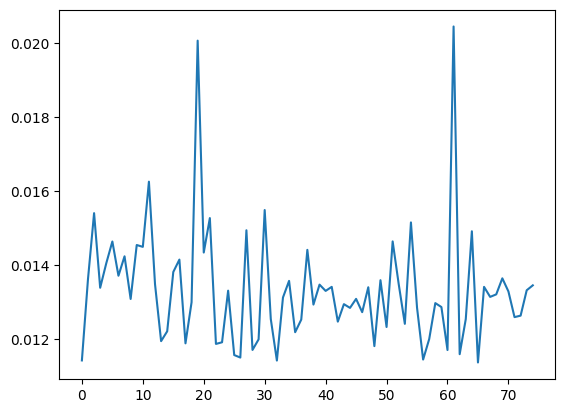

In [257]:
plt.figure()
plt.plot(model(t.tensor([[63, 45]]))[0, -1].softmax(dim=-1))

If we ignore causality, and look at the token-only embeddings' effects on the 
attention pattern, we should see highlights for all bigram-pairs, and nothing otherwise.

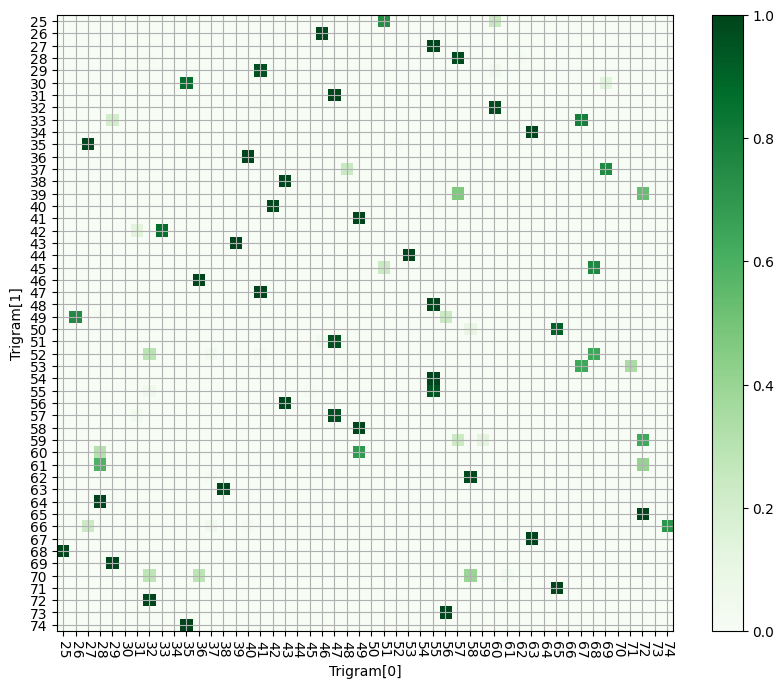

In [208]:
tokens = t.arange(25, model.cfg.n_ctx + 25).unsqueeze(0)
m, c = model.run_with_cache(tokens)

# Token only, no positional embeddings
q_tok = (c['hook_embed']) @ model.W_Q[0, 0] + model.b_Q[0, 0]
k_tok = (c['hook_embed']) @ model.W_K[0, 0] + model.b_K[0, 0]
attn_tok = einops.einsum(q_tok, k_tok, "... qseq dhead, ... kseq dhead -> ... qseq kseq")

fig, ax = plt.subplots(figsize=(10, 8))
ax.grid()
f = ax.imshow(attn_tok[0].softmax(dim=-1), cmap='Greens')
plt.colorbar(f)
plt.xlabel("Trigram[0]")
plt.ylabel("Trigram[1]")
ax.set_xticks(np.arange(dataset.toks.shape[1]), tokens[0].numpy(), rotation=-90)
ax.set_yticks(np.arange(dataset.toks.shape[1]), tokens[0].numpy())
plt.show()

Indeed, we can read off the values of our trigram-starting pairs by:

1. Pick a value from the y-axis. This is a given query value.
2. Read from left to right, until we encounter a large value.
3. From this highlighted square, read off the x-axis value. This is the key value.
4. Our trigram will then be  (key value, query value, \[completion\]).

That is,
for each highlighted square, we have an encoded form of the trigram, as (x_coord, y_coord, \[completion\])

## Explanation of how it works, so far:
### Token Embeddings
The query vector looks for a token that precedes it in a trigram. 

E.g. for token 47, the query vector is looking for 2, 4, or 41.

The key vector indicates which token it represents. I.e. for token 41,
the key vector says "I am 41".

### Positional Embeddings
The positional embeddings lead to a monotonic, essentially linear
increase based on position in the attention pattern. 

That is, the attention score increases linearly reading from
start to end of the token stream.

This means that the highest attention score is, by default, 
always the current token.

### Combined

Combining the two embeddings, the algorithm for detecting trigrams
is laid bare:

1. Use token embeddings to determine if a preceding token matches
the current token. That is, increase attention when (key == trigram[0]) and (query == trigram[1]).
3. Use positional embeddings to mask out all such starting pairs
*unless* it is the immediately preceding token.


The one notable exception to this are trigrams with repeats, e.g. (72, 72, 48). 
In this case, the trigram **does not** attend to itself. This makes some sense, because
the monotonic nature of the learned positional embeddings mean if two tokens are both a match for the query,
the head only attends to the latest token. Also, the information moved by the OV
circuit would move the same information (based on token embedding, at least) 
whether it attended to the current token or the previous token, since they are the same.

This might suggest the MLP directly implements predictions for repeated tokens.
*However*, there's no real way for the MLP to get information about the previous token without
an attention head playing ball and telling it the current token is a repeat. 
Since the positional embedding scheme in the single head present doesn't do that,
there's really only one avenue left for the model to predict completions of duplicate-starting
trigrams: fake it!

Since a duplicate trigram can never have two different completions, the model can always
guess the correct completion, regardless of whether the current token is a duplicate.
As long as the guess isn't *too* confident, the model won't be penalized much.

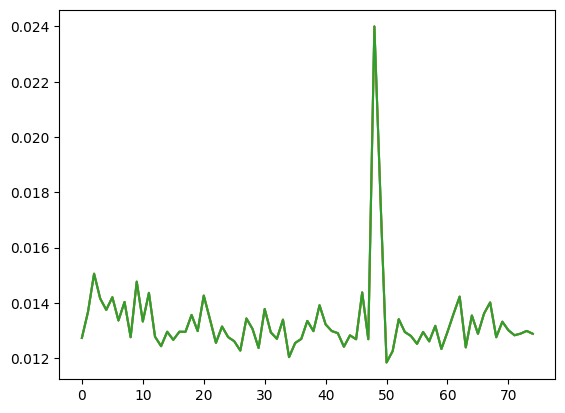

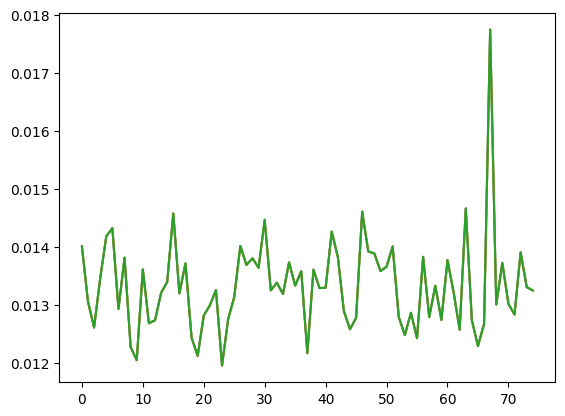

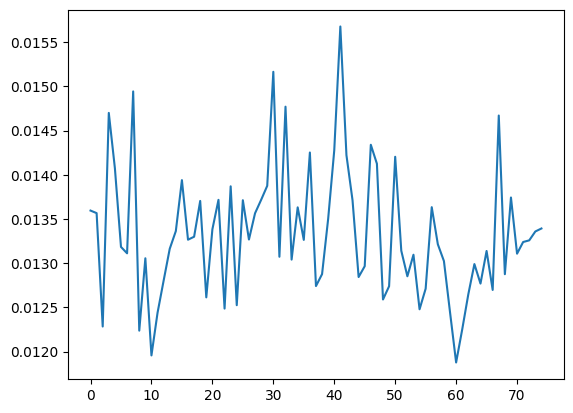

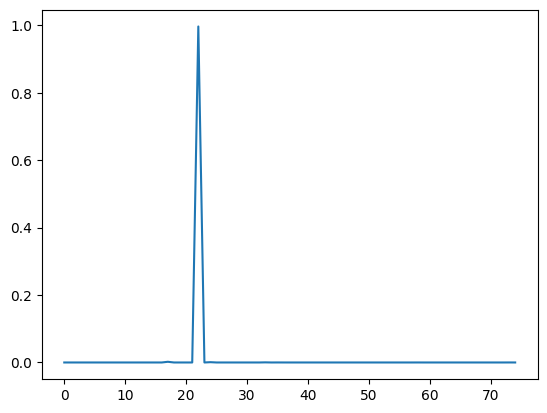

In [244]:
# a series of random tokens (of the same sequence length)
# that end in 54
plt.figure()
plt.plot(model(t.tensor([[72, 72]]))[0, -1].softmax(dim=-1))
plt.plot(model(t.tensor([[1, 72]]))[0, -1].softmax(dim=-1))
plt.plot(model(t.tensor([[74, 72]]))[0, -1].softmax(dim=-1))

# a series of random tokens (of the same sequence length)
# that end in 54
plt.figure()
plt.plot(model(t.tensor([[54, 54]]))[0, -1].softmax(dim=-1))
plt.plot(model(t.tensor([[1, 54]]))[0, -1].softmax(dim=-1))
plt.plot(model(t.tensor([[74, 54]]))[0, -1].softmax(dim=-1))

# two random tokens that are not a trigram
plt.figure()
plt.plot(model(t.tensor([[32, 52]]))[0, -1].softmax(dim=-1))

# two random tokens that **are** a trigram
plt.figure()
plt.plot(model(t.tensor([[26, 49]]))[0, -1].softmax(dim=-1))

We can see that the model makes exactly the same predictions regardless of the preceding token, and that this
prediction lines up with the correct trigram completion.

# How does the model predict the next token?

We're fairly sure how the model detects that a trigram is present. How, then, does it 
go about correctly predicting the completion?

Also, given some trigrams fail to be predicted, can we 

1. Detect whether their failure happens in detection or in prediction, and
2. Modify the model to fix this problem?

## Prediction

We know a few things at this point:

- By default, the attention head attends to itself. Therefore,
when no trigrams are present, the residual stream entering the MLP
should contain the token's own embedding and a copy of that embedding,
transformed via the OV circuit. That is:

     x_mid = trigram[1] + OV @ trigram[1]
- If a trigram is detected, the OV circuit instead copies and transforms the
residual stream from trigram[0], that is:

    x_mid = trigram[1] + OV @ trigram[0]


It seems possible that the next-token prediction could be implemented without 
the use of MLP layers at all. We can see if this is the case
by mean-ablating the effect of the MLP. 

In other words, 
    x_final = x_mid + const


In [231]:
batch = 10
trigram_seq_positions, trigram_completions = get_trigram_seq(dataset, batch)
print(f"{trigram_seq_positions = }")
print(f"""Correct Completions = {trigram_completions}
Midstream Completions = {(cache['blocks.0.hook_resid_mid'][batch, trigram_seq_positions] @ model.W_U).argmax(dim=-1)}
Final Completions = {(cache['blocks.0.hook_resid_post'][batch, trigram_seq_positions] @ model.W_U).argmax(dim=-1)}
""")


def calc_prediction_stats(stream=cache["blocks.0.hook_resid_mid"]):
    # What fraction of completions, calculated by 
    # unembedding a given residual stream, are correct?
    correct = 0
    total = 0
    
    for batch, stream in enumerate(stream):
        t_seq, t_completions = get_trigram_seq(dataset, batch)
        midstream_prediction = (stream[t_seq] @ model.W_U).argmax(dim=-1)
        num_correct = (midstream_prediction == t.tensor(t_completions)).int().sum(dim=0)
    
        correct += num_correct
        total += len(t_completions)
    
    return correct / total

print(f"Embeddings Only: fraction correct = {calc_prediction_stats(cache["blocks.0.hook_resid_pre"])}")
print(f"Attention: fraction correct = {calc_prediction_stats(cache["blocks.0.hook_resid_mid"])}")
print(f"MLP: fraction correct = {calc_prediction_stats(cache["blocks.0.hook_resid_post"])}")

trigram_seq_positions = [15, 25]
Correct Completions = [34, 64]
Midstream Completions = tensor([40, 64])
Final Completions = tensor([34, 64])

Embeddings Only: fraction correct = 0.14229880273342133
Attention: fraction correct = 0.18067152798175812
MLP: fraction correct = 0.9522117376327515


We can see that, directly projected, attention only slightly improves
the token prediction above using the embeddings only. 

To figure out if the MLP is adding logic, or just redirecting information,
we can linearize it and see how much of an effect that has on the logits.

In [17]:
t.set_grad_enabled(True)
def attach_jacobian_hooks(module_upstream,
                          module_downstream,
                          network,
                          stop_idx_downstream,
                          start_idx_downstream=0):
    """Calculate the jacobian matrix, that links an upstream
       hidden layer with a downstream layer.

       Returns: (calc_jacobian(), remove_hooks())

       You must run a forward pass through the model
       before the gradients tensor will be populated.
    """

    # this probably only works for linear layers
    n_outputs = stop_idx_downstream - start_idx_downstream

    # Make sure we aren't unnecessarily calculating
    # gradients where we don't need them
    network.requires_grad_(False)

    capture = {}

    def setup_upstream_hook(module, inp, out):
        capture['upstream_vec'] = out

        out = einops.repeat(out,
                            "batch ... d_hidden -> (batch d_out) ... d_hidden",
                            d_out=n_outputs)

        # setup a do-nothing vector to let us extract the gradients
        # of this intermediate layer

        # Annoyingly, because we have to coerce the output dimension
        # into (batch d_out), we can't cut down the size
        # of the capture tensor. So, any dimension that is
        # mean'd out will have a duplicate vector for each original
        # dimension before the mean.

        # output_shape = [val for i, val in enumerate(out.shape) if i not in mean_dims]
        output_shape = out.shape

        capture['upstream_grad'] = t.zeros(output_shape, requires_grad=True, device=out.device)

        return out + capture['upstream_grad']

    def setup_downstream_hook(module, inp, out):
        # Extract the jacobian dimension we snuck
        # into the batch dimension.
        out = einops.rearrange(out,
                               "(batch d_out) ... d_hidden -> batch ... d_out d_hidden",
                               d_out=n_outputs)

        # if mean_dims:
        #     out = out.mean(dim=mean_dims, keepdim=True)
        out[..., start_idx_downstream : stop_idx_downstream].backward(
            t.eye(n_outputs, device=out.device).repeat(*out.shape[:-2], 1, 1))

    remove_upstr_hook = module_upstream.register_forward_hook(setup_upstream_hook)
    remove_downstr_hook = module_downstream.register_forward_hook(setup_downstream_hook)

    def remove_hooks():
        remove_upstr_hook.remove()
        remove_downstr_hook.remove()

    def get_jacobian():
        if capture.get("upstream_grad") is None:
            raise RuntimeError("Gradients must be initialized by "
                               "running a forward pass through "
                               "the model before they can be  "
                               "accessed.")
        rearranged = einops.rearrange(capture['upstream_grad'].grad,
                                "(batch d_out) ... d_in -> batch ... d_out d_in",
                                d_out=n_outputs)
        return rearranged
    def get_upstream_vec():
        if capture.get("upstream_vec") is None:
            raise RuntimeError("Vectors must be initialized by "
                               "running a forward pass through "
                               "the model before they can be  "
                               "accessed.")

        return capture['upstream_vec']

    return get_jacobian, get_upstream_vec, remove_hooks

In [145]:
jacs = []

for i in range(dataset.toks.shape[0]):
    model = reload_model()
    model.requires_grad_(True)
    get_jacobian, get_upstream_vec, remove_hooks = attach_jacobian_hooks(model.blocks[0].hook_resid_mid, model.blocks[0].hook_resid_post, model, model.cfg.d_model)

    # Run a forward pass through the model
    model(dataset.toks[i: i + 1]) 

    jacs += [get_jacobian()]
    
    remove_hooks()

jacobian = t.cat(jacs)

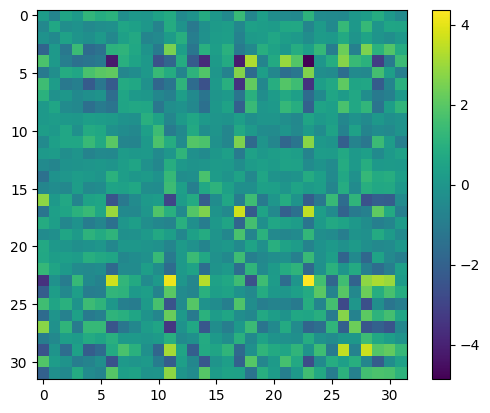

In [168]:
jac_mean = jacobian.mean(dim=[0, 1])
plt.figure()
f = plt.imshow(jac_mean.inverse() @ jacobian[0, 15])
plt.colorbar(f)

tensor([12, 10])
tensor([55, 16, 54])


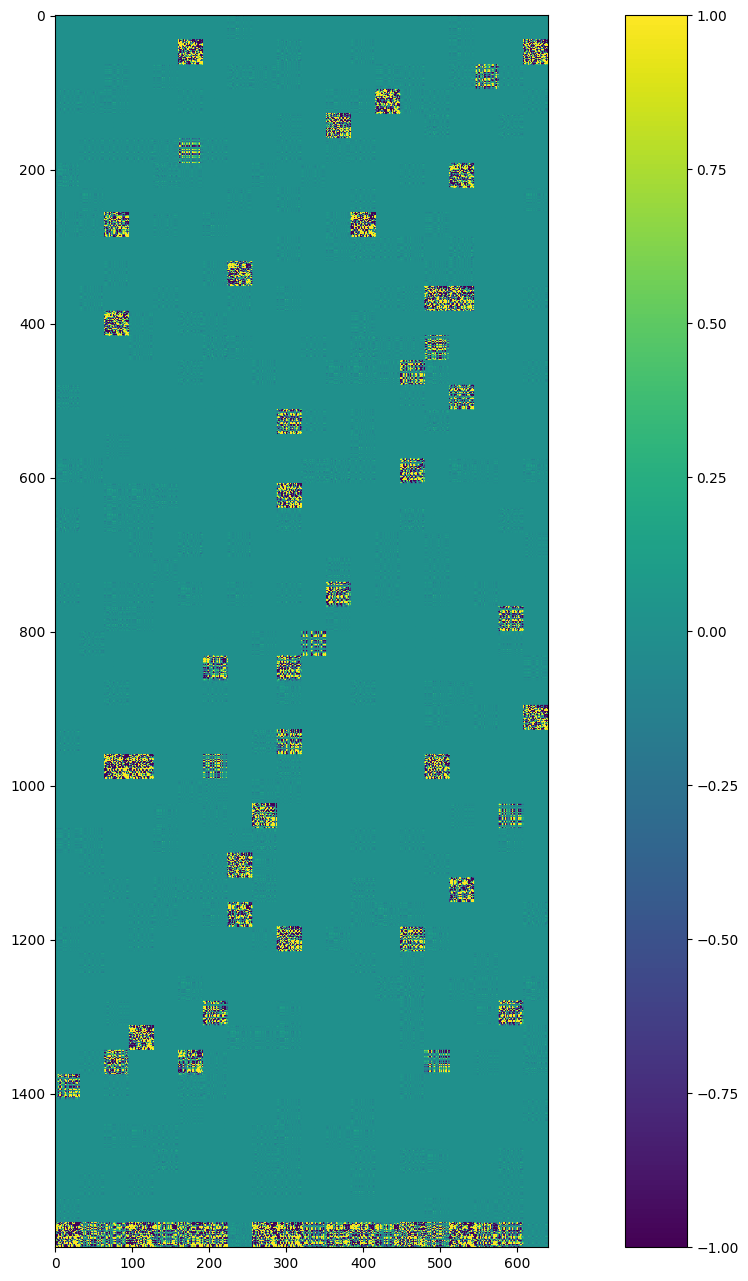

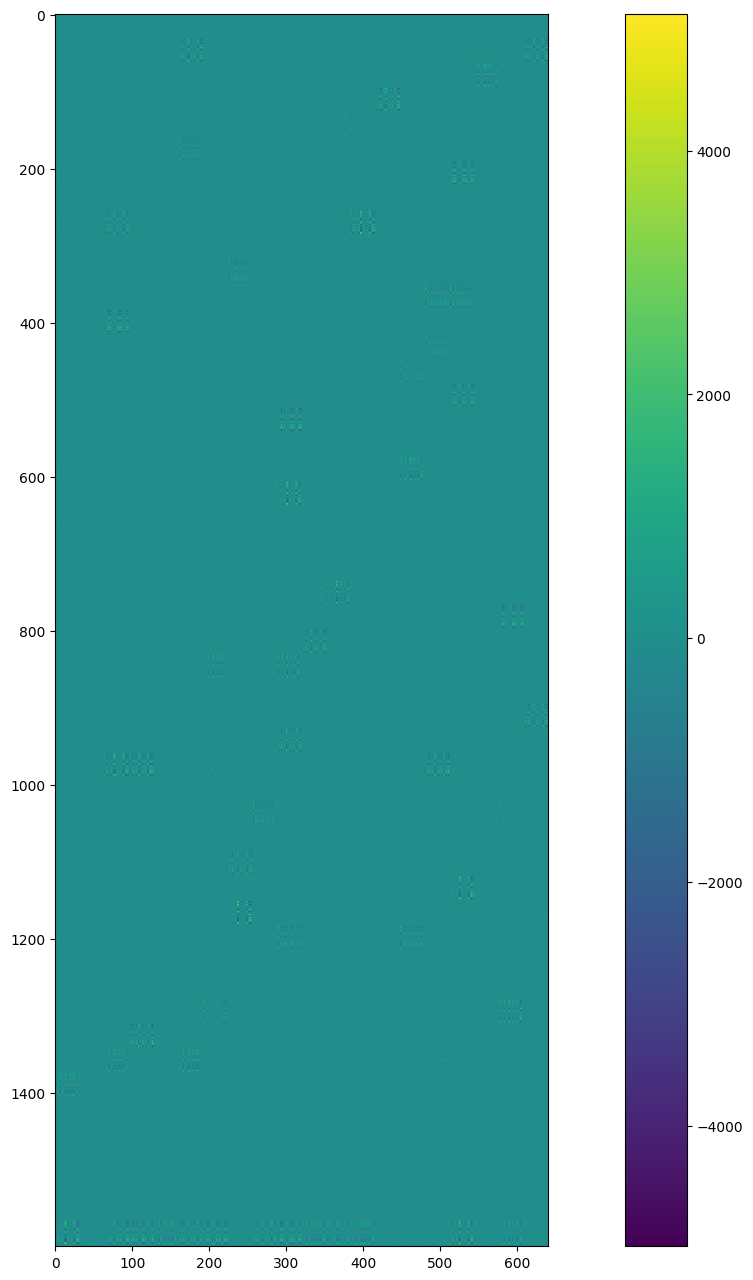

In [321]:
print(dataset.toks[0, 2:4])
print(dataset.toks[1, 4:7])

fig, ax = plt.subplots(figsize=(20, 16))
f = ax.imshow(einops.rearrange(jacobian[:20] - jacobian[0, 0], "batch seq d_res1 d_res2 -> (seq d_res1) (batch d_res2)"), vmin=-1, vmax=1)
plt.colorbar(f)

fig, ax = plt.subplots(figsize=(20, 16))
f = ax.imshow(einops.rearrange(jacobian[0, 0].inverse() @ jacobian[:20], "batch seq d_res1 d_res2 -> (seq d_res1) (batch d_res2)"))
plt.colorbar(f)

[8, 12, 30, 42]


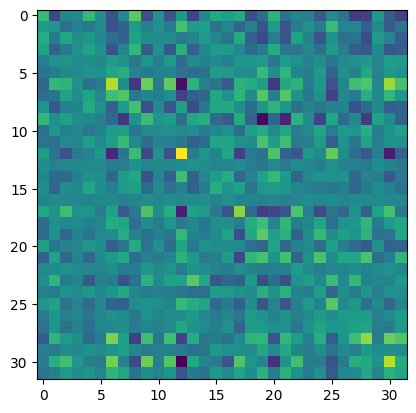

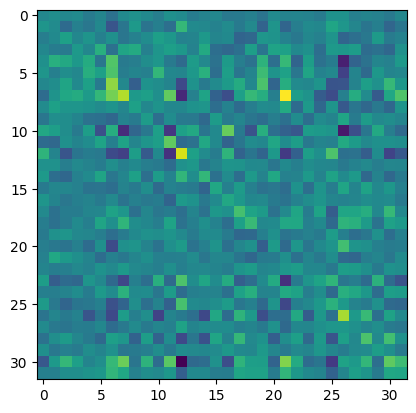

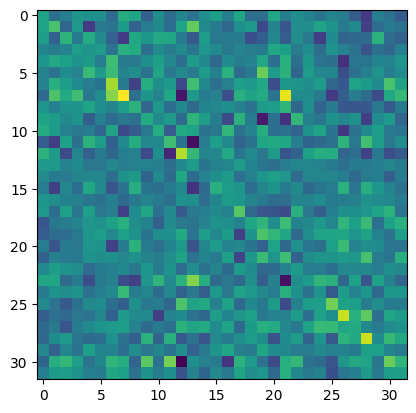

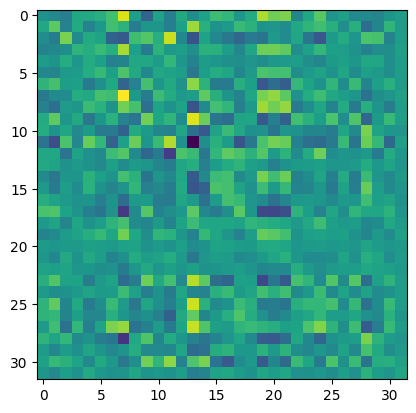

In [271]:
batch = 2
seq, completions = get_trigram_seq(dataset, batch)
print(seq)

for pos in seq:
    plt.figure()
    plt.imshow(jacobian[batch, pos])

In [272]:
projected = einops.einsum(cache["blocks.0.hook_resid_mid"][0], jacobian[0], "seq d_model_in, seq d_model_out d_model_in -> seq d_model_out")

# Verify the bias does not change with each sequence position
assert t.allclose((cache["blocks.0.hook_resid_post"][0] - projected)[0], (cache["blocks.0.hook_resid_post"][0] - projected)[10], rtol=5e-4)

mlp_bias = cache['blocks.0.hook_resid_post'][0, 0] - projected[0]

In [275]:
linearized_mlp_post = einops.einsum(cache["blocks.0.hook_resid_mid"], jac_mean, "batch seq d_model_in, d_model_out d_model_in -> batch seq d_model_out") + mlp_bias

print(f"Prediction success rate (of trigrams) without MLP: {calc_prediction_stats(linearized_mlp_post).item()}")

Prediction success rate (of trigrams) without MLP: 0.23414461314678192


So, the MLP layer applies some non-zero scaling and translation to all elements by default. 
If we apply just these transformations, we get a modest improvement in prediction.

That is to say, if we recentred the unembeddings such that `mlp_bias = 0` and `jac_mean = Identity`,
we could still predict the correct token around 23% of the time. 

If we calculate the mean number of "partners" a given trigram activation can have:

In [274]:
mean_partners = np.mean([sum([t[1] == trigram[1] for t in dataset.trigrams]) for trigram in dataset.trigrams])
print(f"Mean partners = {mean_partners}")
print(f"Expected success rate of randomly guessing a continuation = {1 / mean_partners}")

Mean partners = 4.458483754512636
Expected success rate of randomly guessing a continuation = 0.2242914979757085


In other words, if the model knows that it needs to predict a trigram continuation, it 
could just use bigram statistics on the current token (which is `trigram[1]`) to guess
uniformly from the set of trigrams that share `trigram[1]`.

That is, the bigram would be `trigram[1] -> trigram[2]`.

To see if this is what it is doing, we can look at the predictions made by the linearized mlp

In [201]:
from collections import defaultdict

bigram_0_lookup = defaultdict(list)
bigram_1_lookup = defaultdict(list)

for trigram in dataset.trigrams:
    bigram_0_lookup[trigram[0]] += [trigram[2]]
    bigram_1_lookup[trigram[1]] += [trigram[2]]

# Check if the prediction (without mlp) comes
# from the set of bigrams
bigram_0_correct = 0
bigram_1_correct = 0
num = 0


for batch in range(dataset.toks.shape[0]):
    seq, completions = get_trigram_seq(dataset, batch)
    for pos, comp in zip(seq, completions): 
        prediction = (linearized_mlp_post[batch, pos] @ model.W_U).argmax(dim=-1)
        bigram_0_predictions = bigram_0_lookup[dataset.toks[batch, pos].item()]
        bigram_1_predictions = bigram_1_lookup[dataset.toks[batch, pos].item()]
        
        bigram_0_correct += prediction in bigram_0_predictions
        bigram_1_correct += prediction in bigram_1_predictions
        num += 1

print(f"Fraction Predictions in Bigram[0]: {bigram_0_correct / num}")
print(f"Fraction Predictions in Bigram[1]: {bigram_1_correct / num}")


Fraction Predictions in Bigram[0]: 0.04992005684846332
Fraction Predictions in Bigram[1]: 0.4068218155977971


So, while the model (sans MLP) does often predict bigram completions,
and these skew towards predicting based on the current token 
(and not the previous token), the majority of the time
the model *does not predict using bigram statistics*.

In [215]:
model(t.tensor([[1, 72]]))[0, -1].argmax(dim=-1)

tensor(48)

What trigrams does the model fail to detect?

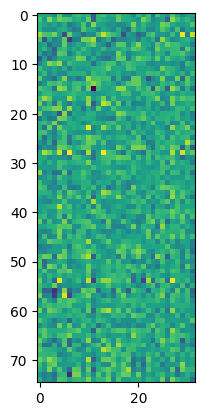

In [332]:
plt.imshow(model.W_E @ model.W_V[0, 0] @ model.W_O[0, 0])

In [336]:
(model.W_V[0, 0] @ model.W_O[0, 0])

torch.Size([32, 32])

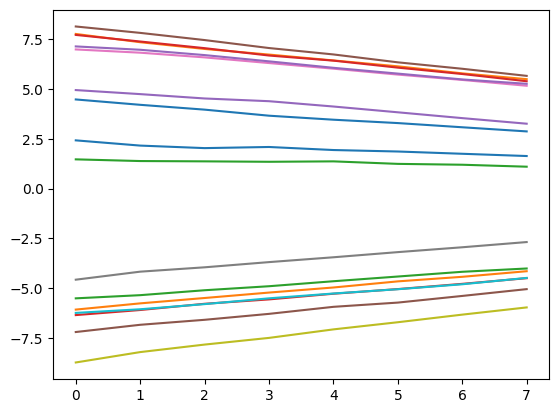

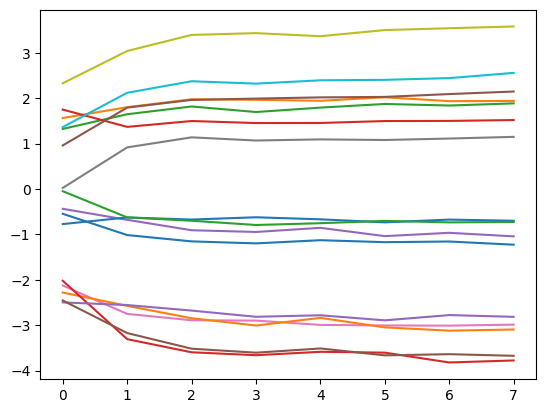

In [351]:
plt.plot(model.W_pos[:8] @ model.W_K[0, 0])
plt.figure()
plt.plot(model.W_pos[:8] @ model.W_Q[0, 0])


## Can we at least use the MLP as a black box and get it to spit out trigram completions?

In [352]:
for trigram in dataset.trigrams:
    
    print(trigram)

(17, 0, 43)
(45, 10, 47)
(2, 47, 28)
(34, 53, 47)
(10, 2, 67)
(17, 44, 15)
(22, 37, 37)
(49, 58, 28)
(46, 26, 42)
(59, 14, 68)
(58, 50, 45)
(56, 49, 0)
(61, 58, 56)
(1, 68, 72)
(9, 14, 65)
(2, 23, 55)
(12, 45, 61)
(32, 72, 3)
(56, 73, 3)
(69, 37, 61)
(15, 4, 50)
(40, 37, 47)
(72, 19, 18)
(57, 4, 73)
(32, 28, 18)
(11, 63, 36)
(13, 1, 22)
(16, 14, 5)
(41, 29, 41)
(6, 13, 39)
(55, 27, 72)
(65, 50, 67)
(7, 42, 17)
(10, 29, 34)
(37, 62, 61)
(22, 15, 20)
(52, 72, 62)
(16, 43, 68)
(71, 13, 62)
(42, 13, 69)
(55, 40, 20)
(12, 9, 26)
(13, 53, 35)
(67, 6, 72)
(55, 19, 0)
(68, 44, 45)
(42, 26, 51)
(13, 35, 72)
(28, 64, 11)
(19, 40, 68)
(18, 44, 6)
(21, 58, 42)
(54, 49, 65)
(69, 22, 4)
(59, 13, 73)
(36, 56, 32)
(41, 47, 3)
(63, 45, 19)
(61, 63, 32)
(46, 51, 54)
(69, 30, 14)
(57, 0, 34)
(9, 20, 2)
(9, 71, 20)
(28, 60, 43)
(43, 38, 67)
(27, 35, 8)
(13, 44, 13)
(39, 40, 62)
(20, 54, 10)
(11, 9, 30)
(5, 73, 25)
(47, 24, 0)
(36, 70, 33)
(55, 48, 26)
(54, 50, 32)
(68, 45, 30)
(9, 22, 2)
(10, 24, 42)
(49,

In [455]:
def attn_predict(trigram_0, trigram_1):
    prev_tok_stream = model.W_pos[0] + model.W_E[trigram_0]
    prev_tok_ov_mover = (prev_tok_stream @ model.W_V[0, 0] + model.b_V[0, 0]) @ model.W_O[0, 0] + model.b_O[0, 0]
    curr_tok_stream = model.W_pos[1] + model.W_E[trigram_1]
    
    resid_mid = prev_tok_ov_mover + curr_tok_stream

    linearized_post_mlp = einops.einsum(resid_mid, jac_mean, "d_model_in, d_model_out d_model_in -> d_model_out")
    
    return ((linearized_post_mlp + mlp_bias) @ model.W_U + model.b_U).argmax(dim=-1)

def mlp_predict(trigram_0, trigram_1):
    prev_tok_stream = model.W_pos[0] + model.W_E[trigram_0]
    prev_tok_ov_mover = (prev_tok_stream @ model.W_V[0, 0] + model.b_V[0, 0]) @ model.W_O[0, 0] + model.b_O[0, 0]
    curr_tok_stream = model.W_pos[1] + model.W_E[trigram_1]
    
    resid_mid = prev_tok_ov_mover + curr_tok_stream
    
    return (model.blocks[0].mlp(resid_mid) @ model.W_U + model.b_U).argmax(dim=-1)

In [456]:
print(attn_predict(72, 72))
print(mlp_predict(54, 54))

tensor(48)
tensor(54)


In [362]:
model.W_O.shape

torch.Size([1, 1, 16, 32])

In [369]:
t.ones(32) @ model.W_V[0, 0] @ model.W_O[0, 0]

torch.Size([32, 32])

(72, 72, 48)

(54, 54, 67)

In [423]:
model(t.tensor([[1, 72]])).argmax(dim=-1)

tensor([[ 8, 48]])

In [426]:
model.b_U

Parameter containing:
tensor([ 0.0059,  0.0028,  0.0266, -0.0047,  0.0205, -0.0364, -0.0226, -0.0564,
         0.1232,  0.0370, -0.0436,  0.0280, -0.0005, -0.0196, -0.0269,  0.0246,
        -0.0643, -0.0149,  0.0413, -0.0236,  0.0155,  0.0101, -0.0386, -0.0052,
        -0.0293, -0.0449, -0.0706, -0.0195, -0.0416, -0.0031, -0.0041, -0.0215,
         0.0523,  0.0343,  0.0310, -0.0066, -0.0372, -0.0488,  0.0161,  0.0390,
         0.0044,  0.0291,  0.0072, -0.0707, -0.0409,  0.0097,  0.0137,  0.0460,
         0.1184,  0.0134,  0.0240, -0.0824,  0.0985, -0.0171, -0.0239, -0.0117,
         0.0916, -0.0350, -0.0087, -0.1063,  0.0076,  0.0018,  0.0687, -0.0346,
        -0.0179,  0.0405, -0.0504, -0.0036, -0.0077, -0.0084,  0.0267, -0.0473,
         0.0808,  0.0318,  0.0125])

In [437]:
model.embed(t.tensor([[72]]))

tensor([[[ 0.1020,  0.2391,  0.1150, -0.5506, -0.5245, -0.5589,  1.0967,
          -0.0398,  0.3893, -0.2209,  0.0959,  1.0104,  0.0866, -0.2605,
          -0.0955,  0.2011,  0.2749, -0.7794, -0.1519,  0.3699,  0.1509,
          -0.2072,  0.1045,  0.2152, -0.4597,  0.3018,  0.4027, -0.2518,
           0.8471, -0.6139,  0.1014,  0.0165]]])

In [450]:
(model.W_E[72] + model.W_pos[0] + model.b_in)

RuntimeError: The size of tensor a (32) must match the size of tensor b (20) at non-singleton dimension 1

In [451]:
dir(model)

['OV',
 'QK',
 'T_destination',
 'W_E',
 'W_E_pos',
 'W_K',
 'W_O',
 'W_Q',
 'W_U',
 'W_V',
 'W_gate',
 'W_in',
 'W_out',
 'W_pos',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backward_hooks',
 '_backward_pre_hooks',
 '_buffers',
 '_call_impl',
 '_compiled_call_impl',
 '_enable_hook',
 '_enable_hook_with_name',
 '_enable_hooks_for_points',
 '_forward_hooks',
 '_forward_hooks_always_called',
 '_forward_hooks_with_kwargs',
 '_forward_pre_hooks',
 '_forward_pre_hooks_with_kwargs',
 '_get_backward_hooks',
 '_get_backward_pre_hooks',
 '_get_name',
 '_init_weights_gpt2',
 '_in